In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)

from libs.lib import *

d:\ads_test


In [2]:
wandb.init(project="ads_nckh_fraud_detection")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [3]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [4]:
exps_dir = "../../../exps"
# exps_dir = sys.argv[3]

if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [5]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(656, 42) (656, 2) (324, 42) (324, 2)
(1001, 42) (1001, 2) (324, 42) (324, 2)
(1002, 42) (1002, 2) (324, 42) (324, 2)
(355, 42) (355, 2) (324, 42) (324, 2)
10


In [6]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0, 1: 1.0}

In [7]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)

In [8]:
x_test.shape

(330, 42)

In [9]:
x_train.shape

(1022, 42)

#### * Xây dựng model:

In [10]:
#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)
#y_train

In [11]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

In [12]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [13]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [15]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [16]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(42,1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size =3
filter_size=128


# # Block 1
# x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
# x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
# x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# # Block 2
# x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
# x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
# x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# # Block 3
# x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
# x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
# x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
# x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# # Block 4
# x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
# x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
# x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
# x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# # Block 5
# x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
# x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
# x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
# x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# # x = Flatten(name='flatten')(x)
# # x = Dense(dense_units, activation='relu', name='fc1')(x)
# # x = Dense(dense_units, activation='relu', name='fc2')(x)
# # x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

# x = GlobalAveragePooling1D()(x)
# # x = GlobalMaxPooling1D()(x)
# x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification

# # Create model.
# model = Model(x_input, x, name='vgg16')
# # model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# # model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# # model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
# early_stopping = EarlyStopping(monitor='val_accuracy',
#     # min_delta=0.00005,
#     patience=60,
#     verbose=1,
#     restore_best_weights=True,
# )

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.95,
#     patience=10,
#     min_lr=0.000001,
#     verbose=1,
# )


In [17]:
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Concatenate, Input, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf



# Input layer
x_input = Input(shape=(42, 1))

# Block 1
x1 = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x1 = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x1)
x1 = MaxPooling1D(2, strides=2, name='block1_pool')(x1)

# Block 2
x2 = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x1)
x2 = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x2)
x2 = MaxPooling1D(2, strides=2, name='block2_pool')(x2)

# Block 3
x3 = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x2)
x3 = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x3)
x3 = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x3)
x3 = MaxPooling1D(2, strides=2, name='block3_pool')(x3)

# Block 4
x4 = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x3)
x4 = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x4)
x4 = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x4)
x4 = MaxPooling1D(2, strides=2, name='block4_pool')(x4)

# # Block 5
# x5 = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x4)
# x5 = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x5)
# x5 = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x5)
# x5 = MaxPooling1D(2, strides=2, name='block5_pool')(x5)

# Lớp tùy chỉnh để thay đổi kích thước các tensor
class ResizeLayer(Layer):
    def __init__(self, target_length, target_filters, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_length = target_length
        self.target_filters = target_filters

    def build(self, input_shape):
        self.pooling = MaxPooling1D(pool_size=input_shape[1])
        self.conv = Conv1D(self.target_filters, 1, activation='relu', padding='same')

    def call(self, inputs):
        x = self.pooling(inputs)
        x = self.conv(x)
        return x

# Tạo các lớp ResizeLayer cho mỗi tensor
target_length = 1
target_filters = 1024

x1_resized = ResizeLayer(target_length, target_filters)(x1)
x2_resized = ResizeLayer(target_length, target_filters)(x2)
x3_resized = ResizeLayer(target_length, target_filters)(x3)
x4_resized = ResizeLayer(target_length, target_filters)(x4)
# x5_resized = ResizeLayer(target_length, target_filters)(x5)

# Ghép nối các hypercolumns
hypercolumns = Concatenate(axis=1)([x1_resized, x2_resized, x3_resized, x4_resized])

# Các lớp cuối cùng
x = GlobalAveragePooling1D()(hypercolumns)
x = Dense(2, activation='softmax', name='predictions')(x)

model = Model(x_input, x, name='vgg16')

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# # model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# # model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# # model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(learning_rate=0.0001), loss=dice_coef_loss, metrics=['accuracy',f1_score])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.95,
    patience=5,
    min_lr=0.000001,
    verbose=1,
)


In [18]:
model.summary()

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 42, 1)]              0         []                            
                                                                                                  
 block1_conv1 (Conv1D)       (None, 42, 128)              512       ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv1D)       (None, 42, 128)              49280     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling1D)  (None, 21, 128)              0         ['block1_conv2[0][0]']        
                                                                                              

In [19]:
#Set data order
data_order = 8

In [20]:
model.fit(x=dict_data[data_order][0],y=dict_data[data_order][1],
          validation_data=(dict_data[data_order][2],dict_data[data_order][3]),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(),early_stopping,lr_scheduler])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10000
16/16 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5240 - f1_score: 0.5280INFO:tensorflow:Assets written to: d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best)... Done. 0.3s


16/16 [==============================] - 17s 945ms/step - loss: 0.6946 - accuracy: 0.5240 - f1_score: 0.5280 - val_loss: 0.6505 - val_accuracy: 0.7377 - val_f1_score: 0.7396 - lr: 1.0000e-04
Epoch 2/10000
16/16 [==============================] - 11s 698ms/step - loss: 0.6899 - accuracy: 0.5150 - f1_score: 0.5111 - val_loss: 0.7008 - val_accuracy: 0.4198 - val_f1_score: 0.4323 - lr: 1.0000e-04
Epoch 3/10000
16/16 [==============================] - 11s 665ms/step - loss: 0.6839 - accuracy: 0.5359 - f1_score: 0.5352 - val_loss: 0.7226 - val_accuracy: 0.3426 - val_f1_score: 0.3281 - lr: 1.0000e-04
Epoch 4/10000
16/16 [==============================] - ETA: 0s - loss: 0.6585 - accuracy: 0.6547 - f1_score: 0.6544INFO:tensorflow:Assets written to: d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best)... Done. 0.3s


16/16 [==============================] - 14s 905ms/step - loss: 0.6585 - accuracy: 0.6547 - f1_score: 0.6544 - val_loss: 0.6271 - val_accuracy: 0.6543 - val_f1_score: 0.7083 - lr: 1.0000e-04
Epoch 5/10000
16/16 [==============================] - ETA: 0s - loss: 0.5650 - accuracy: 0.7056 - f1_score: 0.7083INFO:tensorflow:Assets written to: d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj\5.deep_learning_model\hypercolumn\wandb\run-20240518_192518-i69wg48p\files\model-best)... Done. 0.3s


16/16 [==============================] - 14s 857ms/step - loss: 0.5650 - accuracy: 0.7056 - f1_score: 0.7083 - val_loss: 0.6105 - val_accuracy: 0.6821 - val_f1_score: 0.7318 - lr: 1.0000e-04
Epoch 6/10000
16/16 [==============================] - 11s 678ms/step - loss: 0.4602 - accuracy: 0.7844 - f1_score: 0.7834 - val_loss: 0.6212 - val_accuracy: 0.7006 - val_f1_score: 0.7474 - lr: 1.0000e-04
Epoch 7/10000
16/16 [==============================] - 10s 642ms/step - loss: 0.4122 - accuracy: 0.8114 - f1_score: 0.8098 - val_loss: 0.6172 - val_accuracy: 0.7130 - val_f1_score: 0.7578 - lr: 1.0000e-04
Epoch 8/10000
16/16 [==============================] - 11s 677ms/step - loss: 0.3392 - accuracy: 0.8623 - f1_score: 0.8632 - val_loss: 0.6579 - val_accuracy: 0.7191 - val_f1_score: 0.7630 - lr: 1.0000e-04
Epoch 9/10000
16/16 [==============================] - 11s 679ms/step - loss: 0.3454 - accuracy: 0.8553 - f1_score: 0.8558 - val_loss: 0.6428 - val_accuracy: 0.7222 - val_f1_score: 0.7266 - lr: 

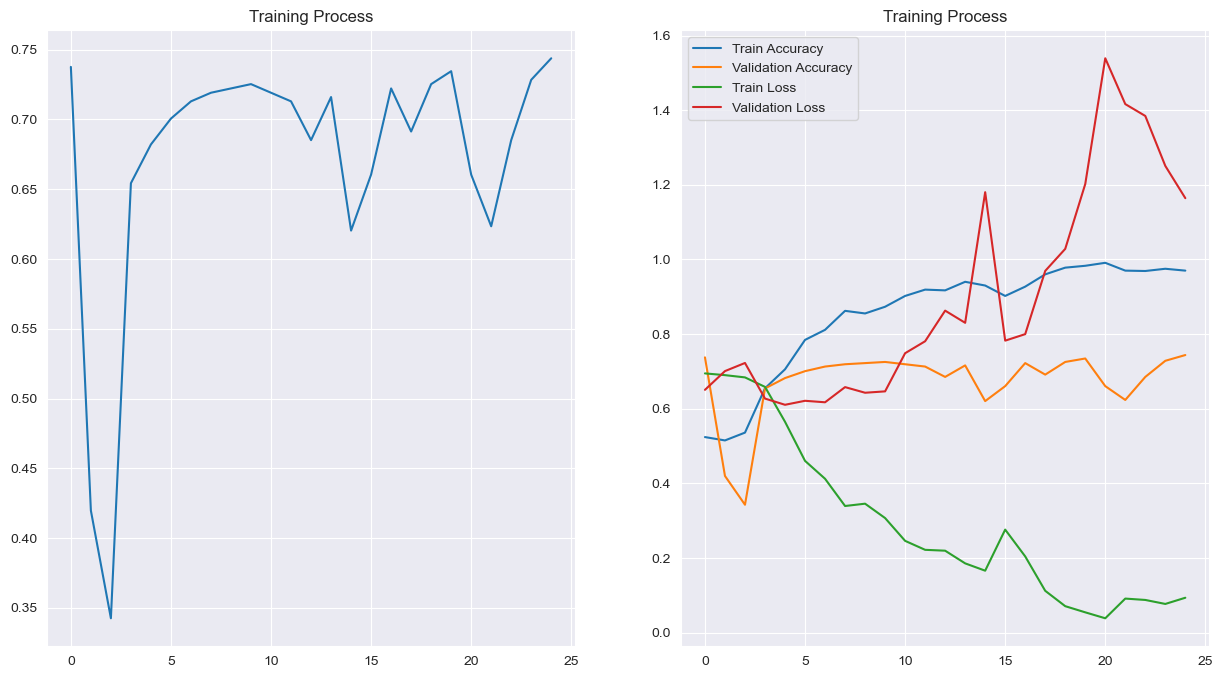

<Figure size 640x480 with 0 Axes>

In [21]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')

axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].legend()

plt.show()
plt.savefig('train.png')

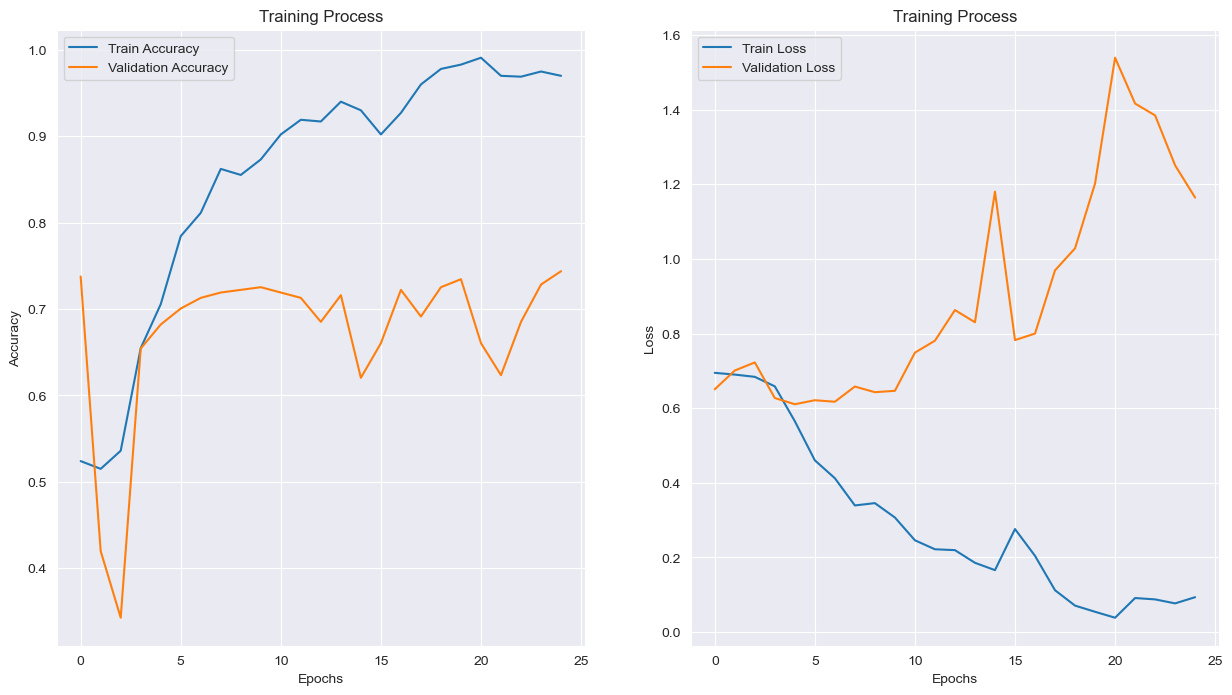

<Figure size 640x480 with 0 Axes>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [23]:
predictions = model.predict(dict_data[data_order][2])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 0s 14ms/step


0.6820987654320988

In [24]:
x_test =dict_data[data_order][2]
y_test=y_list[data_order]

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.6820987654320988
Classification Report:
              precision    recall  f1-score   support

           1       0.38      0.34      0.36        85
           0       0.77      0.80      0.79       239

    accuracy                           0.68       324
   macro avg       0.58      0.57      0.57       324
weighted avg       0.67      0.68      0.68       324



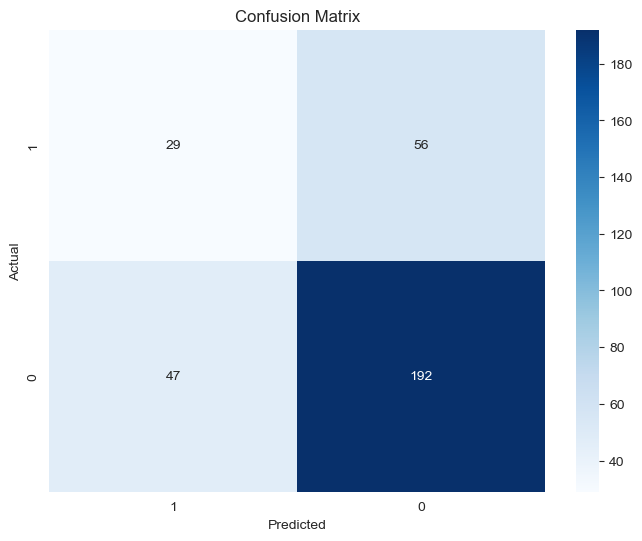

In [26]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

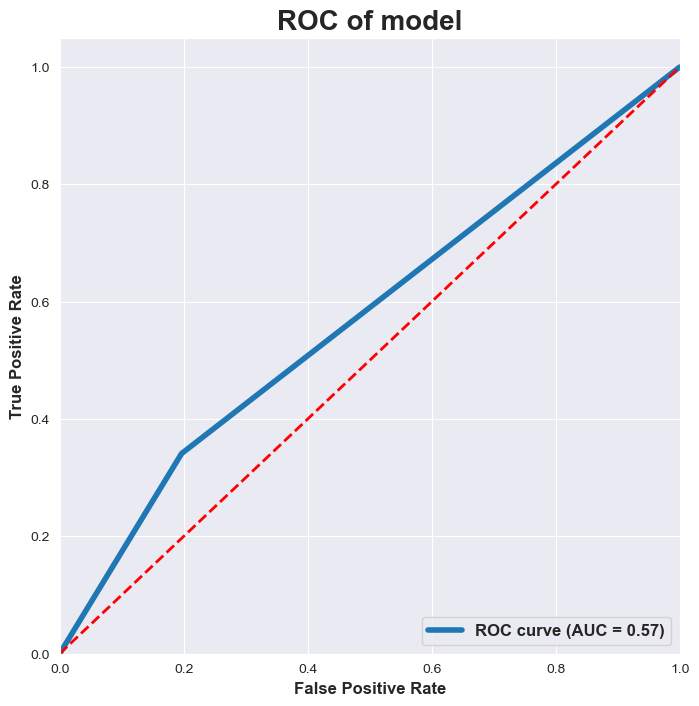

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [28]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [29]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: Y
----------------------------
True: Y
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: Y
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------


In [30]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 221 chiếm khoảng 68.20987654320987% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 29 chiếm khoảng 34.11764705882353% so với thực tế
